## What is this notebook about?

This notebook was used to create ```Fig.4B``` and the analyis numbers of the self-assessments referenced in the text.

The numbers calculated here and other notebooks will be stored under the filepath indicated by the variable `data_reports_fp` for future reference.

In [1]:
# Some imports to get things started
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

sys.path.insert(1, os.path.abspath('/..'))
from utils import set_aspect,save_descriptive_stats
from pathlib import Path

In [2]:
# Load the donation info from the data table
donation_table = pd.read_csv(Path('../data/donation_table.csv'))

# Load messages including those from non-interactive chats
messages_table = pd.read_csv(Path('../data/messages_table.csv'))

# Load filtered messages only from interactive chats
messages_filtered_table = pd.read_csv(Path('../data/messages_filtered_table.csv'))

# Load the questionnaire answers 
survey_info = pd.read_excel(Path('../data/survey.xlsx'))

# Where to save numbers from the analysis
data_reports_fp = Path('../reports/numbers.dat')

# Where to save figures from the analysis
figpath = Path('../reports')


In [3]:
def calculate_gini(intensity):
    """
    Calculate the gini index of an array.  
    Parameters
    ----------
    intensity : array-like
        the intensity of interactions (e.g. total words exchanged).

    Returns
    -------
    index : float
        gini index.

    """
    k = len(intensity)
    intensity = sorted(intensity)
    product = []
    for ind,item in enumerate(intensity):
        product.append(item*(ind+1))
    index = (2*np.sum(product)/(k*np.sum(intensity)))-((k+1)/k)
    return index


In [4]:
all_ginis = []
for source in ['WhatsApp','Facebook']:
    sourceIDs = donation_table[donation_table['source'] == source]['donation_id']
    source_ginis = []
    for donationID in sourceIDs:
        # Get the donor_id for the donation to be able to separate the donor messages
        egoID = donation_table[donation_table['donation_id']==donationID]['donor_id'].iloc[0]    
        
        # Separate the donor messages
        ego_messages = messages_filtered_table[messages_filtered_table['sender_id'] == egoID]
        # Now per chat
        ego_messages_per_chat = ego_messages.groupby('conversation_id').sum()
        # Calculate the Gini index for the ego
        gini = calculate_gini(ego_messages_per_chat['word_count'].values)
        
        # Append for calculating sample stats
        all_ginis.append(gini)
        source_ginis.append(gini)
    # Calculate and save sample stats for the source
    save_descriptive_stats(data_reports_fp,f'{source}_gini',source_ginis)
    
# Calculate and save sample stats for the pooled values from both sources
save_descriptive_stats(data_reports_fp,'all_gini',all_ginis)

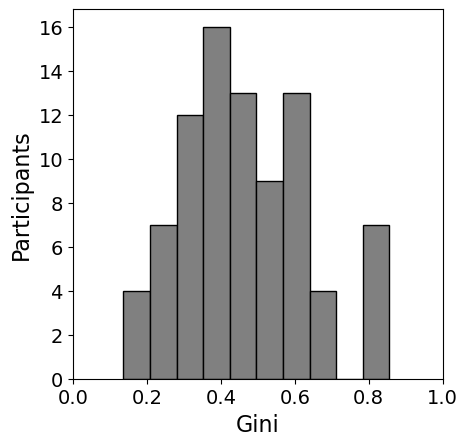

In [5]:
# Plot Fig. 4B
fig, ax = plt.subplots()
ax.hist(all_ginis,color='gray',edgecolor='black')
ax.set_xlabel('Gini', fontsize=16)
ax.set_ylabel('Participants', fontsize=16)
ax.set_xlim(0,1)
ax.tick_params(axis='both', which='major', labelsize=14)
set_aspect(ax)
fig.patch.set_facecolor('white')
fig.savefig(Path(f'{figpath}/gini-hist.svg'),dpi=500)
fig.savefig(Path(f'{figpath}/gini-hist.png'),dpi=500)